# DNN 구현
numpy만을 사용해서 DNN을 구현해보는 것이 목표이다.

In [2]:
import numpy as np

### Forest Cover Type Dataset 불러오기
이진 분류가 목표이기 때문에 라벨 1, 2만을 가져와서 0, 1로 새로운 라벨을 부여했습니다.

In [3]:
from sklearn.datasets import fetch_covtype

data = fetch_covtype()
X_data = data.data      # (m, 54)
y_data = data.target    # (m,)

# 1 또는 2인 애들만 남기기
mask = (y_data == 1) | (y_data == 2)
X = X_data[mask]        # (m_sub, 54)
y_sub = y_data[mask]        # (m_sub,)

# 1 -> 1, 2 -> 0 으로 매핑 (이진 분류)
Y = (y_sub == 1).astype(int)    # (m_sub,)

### 데이터 행렬 차원을 연산이 가능한 형태로 바꾸기 위한 전치

In [4]:
X = X.T

In [5]:
Y = Y.reshape(1, -1)

### 데이터 차원 확인

In [6]:
X.shape

(54, 495141)

In [7]:
Y.shape

(1, 495141)

### 데이터 정규화하기

In [19]:
mu = np.mean(X, axis=1, keepdims=True)
sigma = np.std(X, axis=1, keepdims=True) + 1e-8
X = (X - mu) / sigma

### 데이터 분포 확인

In [8]:
print(f"라벨 0의 개수 : {(Y == 0).sum()}개", end=", ")
print(f"라벨 1의 개수 : {(Y == 1).sum()}개")

라벨 0의 개수 : 283301개, 라벨 1의 개수 : 211840개


### 신경망의 모든 층에 필요한 가중치(W)와 편향(b)을 초기화하는 함수

layer_dims 리스트를 기준으로 각 층의 W, b를 적절한 크기(shape)로 만들어
딥러닝 학습의 출발점이 되는 초기 파라미터 세트를 생성하는 함수이다.

In [9]:
def initialize_parameters(layer_dims, seed = 42):

    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters

### L개의 층으로 구성된 신경망을 순전파(forward propagation)하는 함수

입력 X를 첫 번째 층부터 마지막 층까지 차례로 통과시키면서
각 층의 Z, A를 계산하고, 역전파에 필요한 캐시까지 저장하는 순전파 함수이다.

In [10]:
def L_model_forward(X, parameters, activation):
    A = X
    L = len(parameters)//2
    caches = []

    for l in range(1, L + 1):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        Z = np.dot(W, A) + b
        
        act = activation[l-1]
        if act == "relu":
            A = np.maximum(0, Z)
        elif act == "sigmoid":
            A = 1 / (1 + np.exp(-Z))
        else:
            raise ValueError("unknown activation")
        cache = (A_prev, W, b, Z, A)
        caches.append(cache)
    A_L = A
    return caches, A_L 

### 비용 함수 (cost function)
모델의 출력 A와 정답 Y의 차이를 cross-entropy 식으로 계산해,
현재 모델이 얼마나 잘못 예측하고 있는지를 수치로 나타내는 함수이다.

In [11]:
def cost_function(A_L, Y):
    m = Y.shape[1]
    A_L = np.clip(A_L, 1e-10, 1-1e-10)
    cost = - (1/m) * np.sum(
        Y * np.log(A_L) +
        (1 - Y) * np.log(1 - A_L)
    )
    return float(np.squeeze(cost))

### L개의 층으로 구성된 신경망을 역전파(backward)하는 함수
순전파에서 저장한 cache를 사용해,
출력층부터 입력층까지 모든 W, b에 대한 미분값(dW, db)을 계산하고
이를 한 번에 반환하는 역전파 함수이다.

In [12]:
def L_model_backward(A_L, Y, caches, activation):
    grads = {}
    L = len(caches)
    m = Y.shape[1]

    last_cache = caches[-1]
    A_prev, W, b, Z, A = last_cache
    
    dZ = A_L - Y

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)
    
    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db


    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z, A = cache

        act = activation[l]
        
        if act == "relu":
            dZ = dA * (Z > 0).astype(float)

        elif act == "sigmoid":
            dZ = dA * A * (1 - A)
            
        else:
            raise ValueError("unknown activation in backward")

        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W.T, dZ)
        
        grads[f"dW{l+1}"] = dW
        grads[f"db{l+1}"] = db

    return grads
        

### 파라미터 업데이트
경사하강법(Gradient Descent) 규칙에 따라
W, b를 새로운 값으로 업데이트하여
손실이 감소하는 방향으로 모델을 개선하는 함수

In [13]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return parameters

### main 구현

In [32]:
layer_dims = [54, 32, 16, 1]
activation = ["relu","relu","sigmoid"]
learning_rate = 0.01
num_iters = 10000
best_cost = np.inf
costs = []
parameters = initialize_parameters(layer_dims, seed=42)

for i in range(num_iters):

    caches, A_L = L_model_forward(X, parameters, activation)

    cost = cost_function(A_L, Y)

    costs.append(cost)
    if cost < best_cost:
        best_cost = cost

        best_parameters = {k: v.copy() for k, v in parameters.items()}

    grads = L_model_backward(A_L, Y, caches, activation)

    parameters = update_parameters(parameters, grads, learning_rate)

    if i % 100 == 0:
        print(f"Iteration {i}, Cost = {cost:.4f}")
    
_, A_L_best = L_model_forward(X, best_parameters, activation)
Y_pred = (A_L_best >= 0.5).astype(int)
accuracy = np.mean(Y_pred == Y)
print("Final Accuracy :", accuracy)


Iteration 0, Cost = 1.0403
Iteration 100, Cost = 0.6871
Iteration 200, Cost = 0.6681
Iteration 300, Cost = 0.6584
Iteration 400, Cost = 0.6506
Iteration 500, Cost = 0.6442
Iteration 600, Cost = 0.6388
Iteration 700, Cost = 0.6337
Iteration 800, Cost = 0.6288
Iteration 900, Cost = 0.6238
Iteration 1000, Cost = 0.6187
Iteration 1100, Cost = 0.6136
Iteration 1200, Cost = 0.6085
Iteration 1300, Cost = 0.6033
Iteration 1400, Cost = 0.5982
Iteration 1500, Cost = 0.5932
Iteration 1600, Cost = 0.5884
Iteration 1700, Cost = 0.5838
Iteration 1800, Cost = 0.5793
Iteration 1900, Cost = 0.5750
Iteration 2000, Cost = 0.5708
Iteration 2100, Cost = 0.5669
Iteration 2200, Cost = 0.5631
Iteration 2300, Cost = 0.5595
Iteration 2400, Cost = 0.5560
Iteration 2500, Cost = 0.5528
Iteration 2600, Cost = 0.5496
Iteration 2700, Cost = 0.5466
Iteration 2800, Cost = 0.5437
Iteration 2900, Cost = 0.5410
Iteration 3000, Cost = 0.5384
Iteration 3100, Cost = 0.5360
Iteration 3200, Cost = 0.5336
Iteration 3300, Cost =

### best 파라미터 저장 & best cost print

In [33]:
filename = "best_params.npz"
np.savez(filename, **best_parameters)
print("Saved best parameters to best_params.npz")
print(f"Best Cost: {best_cost:.6f}")

Saved best parameters to best_params.npz
Best Cost: 0.479097


### cost 값 시각화

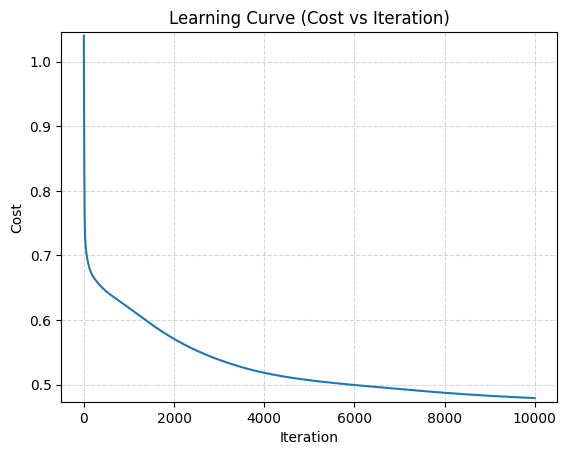

In [34]:
import matplotlib.pyplot as plt

a = np.min(costs)
b = np.max(costs)
pad = (b - a) * 0.01  # 10% padding

plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curve (Cost vs Iteration)")
plt.ylim(a - pad, b + pad)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 모델 평가(Evaluation)

Accuracy: 0.7764576151035766

Classification Report:

              precision    recall  f1-score        support
0              0.795436  0.820248  0.807651  283301.000000
1              0.749147  0.717896  0.733188  211840.000000
accuracy       0.776458  0.776458  0.776458       0.776458
macro avg      0.772291  0.769072  0.770420  495141.000000
weighted avg   0.775631  0.776458  0.775793  495141.000000

Confusion Matrix:
 [[232377  50924]
 [ 59761 152079]]


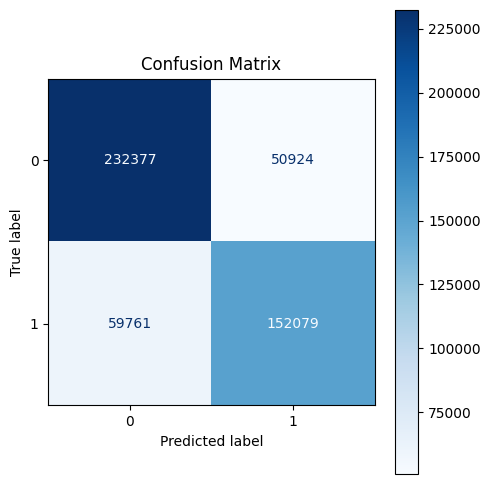

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# 예측값 0/1 변환
y_pred = (A_L >= 0.5).astype(int).reshape(-1)

# 실제값 1차원 변환
y_true = Y.reshape(-1)

# 정확도
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# 정밀도/재현율/F1/Support 모두 포함된 리포트
report_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
print("\nClassification Report:\n")
print(report_df)

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot(cmap="Blues", ax=ax, values_format="d")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()